**Attach Dataset **

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kabilan45/online-retail-ii-dataset")

print("Path to dataset files:", path)

100%|██████████| 43.3M/43.3M [00:00<00:00, 104MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kabilan45/online-retail-ii-dataset/versions/1


##Data Representation

In [3]:
import os
import pandas as pd

# ১. দেখা যাক ফোল্ডারের ভেতর কী ফাইল আছে
print("Checking files in path...")
files = os.listdir(path)
print("Files found:", files)

# ২. অটোমেটিক ফাইলটা লোড করা
file_name = files[0] # প্রথম ফাইলটা নিচ্ছি
full_file_path = os.path.join(path, file_name)

print(f"Loading data from: {file_name} ... (This might take a moment)")

# ফাইল টাইপ চেক করে লোড করা
if file_name.endswith('.csv'):
    df = pd.read_csv(full_file_path)
elif file_name.endswith('.xlsx'):
    df = pd.read_excel(full_file_path)

# ৩. লোড হলে আউটপুট দেখা
print("Success! Data Loaded.")
print(f"Total Rows: {df.shape[0]}")
display(df.head())

Checking files in path...
Files found: ['online_retail_II.xlsx']
Loading data from: online_retail_II.xlsx ... (This might take a moment)
Success! Data Loaded.
Total Rows: 525461


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Current Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


/tmp/ipython-input-1140414261.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


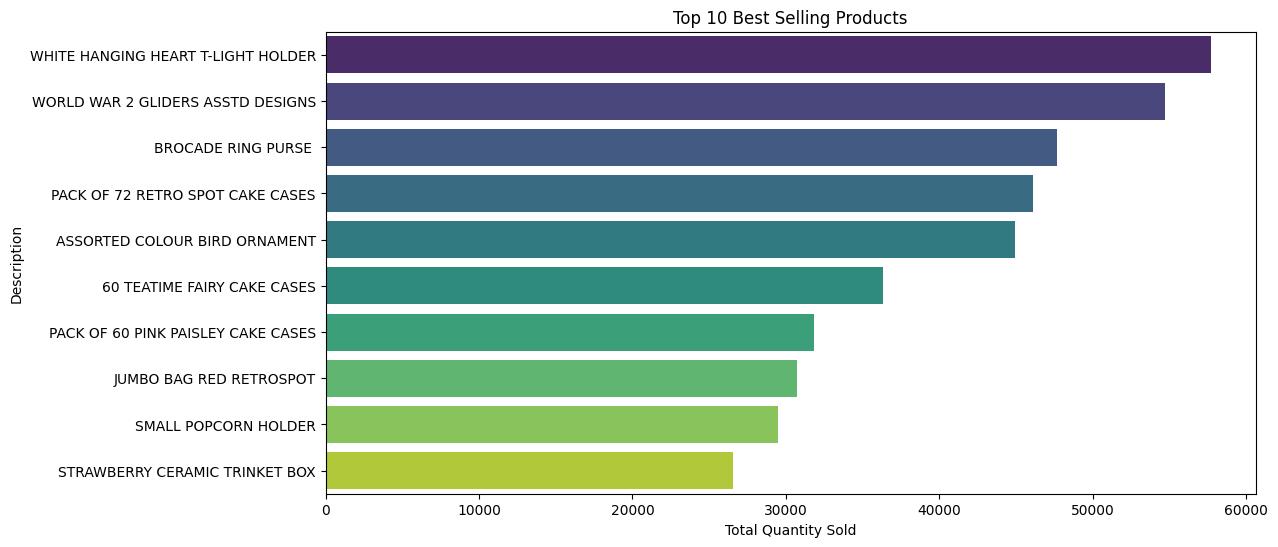

/tmp/ipython-input-1140414261.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette='magma')


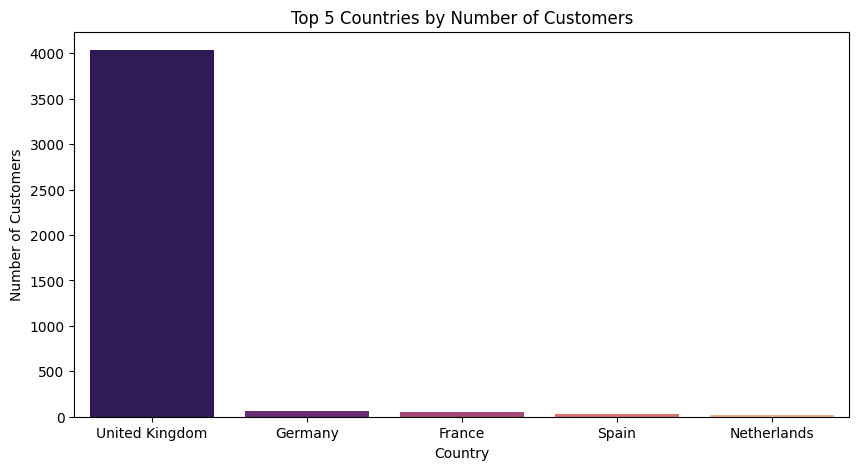

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# ১. আগে কলামের নামগুলো ঠিক করে নিই (Renaming)
# যদি আগেই রিনেম করে থাকো, এই লাইনটা সমস্যা করবে না
df.rename(columns={
    'Invoice': 'InvoiceNo',
    'Price': 'UnitPrice',
    'Customer ID': 'CustomerID'  # স্পেস সরিয়ে দিচ্ছি
}, inplace=True)

# ২. এবার চেক করি রিনেম হলো কি না
print("Current Columns:", df.columns.tolist())

# ৩. গ্রাফ আঁকা (Visualization)
# ---- Graph 1: Top 10 Best Selling Products ----
plt.figure(figsize=(12, 6))
# সবচেয়ে বেশি বিক্রি হওয়া ১০টি প্রোডাক্ট
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Best Selling Products')
plt.xlabel('Total Quantity Sold')
plt.show()

# ---- Graph 2: Top 5 Countries ----
plt.figure(figsize=(10, 5))
# দেশ অনুযায়ী কাস্টমার সংখ্যা
country_counts = df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False).head(5)
sns.barplot(x=country_counts.index, y=country_counts.values, palette='magma')
plt.title('Top 5 Countries by Number of Customers')
plt.ylabel('Number of Customers')
plt.show()

##Data Preprocessing

Column Name replacing

In [6]:
import pandas as pd

# ১. ডেট টাইম ফরম্যাট ঠিক করা (খুবই জরুরি)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# ২. আবার একটু ক্লিন করে নিচ্ছি (যাতে কোনো এরর না থাকে)
# নেগেটিভ ভ্যালু এবং মিসিং আইডি বাদ দিচ্ছি
df_clean = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].dropna()

# ৩. মোট দাম (Total Price) বের করা
df_clean['TotalSum'] = df_clean['Quantity'] * df_clean['UnitPrice']

# ৪. আমরা কবে এনালাইসিস করছি? (ডেটাসেটের শেষ দিনের পরের দিন ধরলাম)
snapshot_date = df_clean['InvoiceDate'].max() + pd.DateOffset(days=1)

print(f"Snapshot Date: {snapshot_date}")

# ৫. মেইন যাদু! (RFM টেবিল তৈরি)
rfm = df_clean.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique', # Frequency (কতগুলো ইউনিক ইনভয়েস)
    'TotalSum': 'sum' # Monetary
})

# ৬. কলামগুলোর নাম সুন্দর করা
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

# ৭. রেজাল্ট দেখা
print("RFM Table Created Successfully!")
print(f"Total Unique Customers: {rfm.shape[0]}")
display(rfm.head())

Snapshot Date: 2010-12-10 20:01:00
RFM Table Created Successfully!
Total Unique Customers: 4312


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


Handling Null Values & Duplicates

In [7]:
# ১. আগে কলামের নামগুলো নিশ্চিত করি (যাতে কোনো এরর না দেয়)
df.rename(columns={
    'Invoice': 'InvoiceNo',
    'Price': 'UnitPrice',
    'Customer ID': 'CustomerID'  # স্পেস সরিয়ে দিচ্ছি
}, inplace=True)

# ২. Null Value চেক করা (কোথায় কতগুলো মিসিং আছে)
print("--- Before Cleaning (Null Values) ---")
print(df.isnull().sum())

# ৩. অ্যাকশন: CustomerID না থাকলে সেই রো রাখার দরকার নেই
df.dropna(subset=['CustomerID'], inplace=True)

# ৪. ডুপ্লিকেট চেক করা এবং রিমুভ করা
print(f"\nDuplicates found: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)

# ৫. ফাইনাল চেক
print("\n--- After Cleaning ---")
print(f"Total Rows: {df.shape[0]}")
print("Null values in CustomerID:", df['CustomerID'].isnull().sum())

--- Before Cleaning (Null Values) ---
InvoiceNo           0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     107927
Country             0
dtype: int64

Duplicates found: 6771

--- After Cleaning ---
Total Rows: 410763
Null values in CustomerID: 0


###Feature EngineeringStep: RFM Feature Engineering
এখানে আমরা ৩টা জিনিস বের করব:

Recency: শেষ কবে এসেছিল?

Frequency: কতবার কিনেছে?

Monetary: মোট কত টাকার কিনেছে?

In [8]:
import pandas as pd
import datetime as dt

# ১. ডেট টাইম ফরম্যাট ঠিক করা
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# ২. নেগেটিভ ভ্যালু (রিটার্ন প্রোডাক্ট) বাদ দেওয়া - এটা খুব জরুরি
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# ৩. মোট দাম (Total Price) বের করা
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

# ৪. আমরা কবে এনালাইসিস করছি? (ডেটাসেটের শেষ দিনের পরের দিন ধরলাম)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# ৫. মেইন কাজ: RFM টেবিল তৈরি
rfm = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique', # Frequency (কতগুলো ইউনিক ইনভয়েস)
    'TotalSum': 'sum' # Monetary
})

# ৬. কলামগুলোর নাম রিনেম করা
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

# ৭. রেজাল্ট দেখা
print("RFM Table Created Successfully!")
print(f"Unique Customers: {rfm.shape[0]}")
display(rfm.head())

/tmp/ipython-input-3887639398.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalSum'] = df['Quantity'] * df['UnitPrice']


RFM Table Created Successfully!
Unique Customers: 4312


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


from matplotlib import pyplot as plt
_df_0['Recency'].plot(kind='hist', bins=20, title='Recency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Frequency'].plot(kind='hist', bins=20, title='Frequency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Monetary'].plot(kind='hist', bins=20, title='Monetary')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='Recency', y='Frequency', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Frequency', y='Monetary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Recency'].plot(kind='line', figsize=(8, 4), title='Recency')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Frequency'].plot(kind='line', figsize=(8, 4), title='Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Monetary'].plot(kind='line', figsize=(8, 4), title='Monetary')
plt.gca().spines[['top', 'right']].set_visible(False)

##**K MEANS Clustering**
Preprocessing & Modeling: Since 'Monetary' and 'Frequency' values have large variance, we apply Log Transformation to reduce skewness and StandardScaler to normalize the data. Finally, we use K-Means Clustering (K=3) to segment customers into 3 groups based on their buying behavior.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# ১. Log Transformation (ডেটার ডিস্ট্রিবিউশন ঠিক করার জন্য)
# np.log1p ব্যবহার করছি যাতে 0 বা নেগেটিভ থাকলে এরর না দেয়
rfm_log = np.log1p(rfm)

# ২. Scaling (সব ভ্যালুকে 0-1 এর রেঞ্জে নিয়ে আসা)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# ৩. K-Means মডেল রান করা (আমরা ৩টি গ্রুপ বা Cluster বানাচ্ছি)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans.fit(rfm_scaled)

# ৪. মেইন টেবিলে Cluster নম্বর বসিয়ে দেওয়া
rfm['Cluster'] = kmeans.labels_

# ৫. রেজাল্ট দেখা: কোন ক্লাস্টারের গড় (Mean) কেমন?
print("Clustering Complete! Here is the summary:")
display(rfm.groupby('Cluster').mean())

Clustering Complete! Here is the summary:


,Recency,Frequency,Monetary
Cluster,,,
0,18.152644,13.252404,7212.056500
1,164.288066,1.295708,313.878955
2,55.410905,3.363125,1272.565843


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# 1. Log Transformation & Scaling (ডেটার রেঞ্জ ঠিক করার জন্য)
rfm_log = np.log1p(rfm)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# 2. K-Means Model Training (৩টি গ্রুপে ভাগ করছি)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans.fit(rfm_scaled)

# 3. অরিজিনাল টেবিলে ক্লাস্টার নম্বর বসানো
rfm['Cluster'] = kmeans.labels_

# 4. ক্লাস্টারগুলোর গড় মান দেখা (Cluster Analysis)
print("Cluster Centers (Mean Values):")
display(rfm.groupby('Cluster').mean())

Cluster Centers (Mean Values):


,Recency,Frequency,Monetary
Cluster,,,
0,55.410905,3.363125,1272.565843
1,164.288066,1.295708,313.878955
2,18.152644,13.252404,7212.056500


from matplotlib import pyplot as plt
_df_8['Recency'].plot(kind='hist', bins=20, title='Recency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Frequency'].plot(kind='hist', bins=20, title='Frequency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Monetary'].plot(kind='hist', bins=20, title='Monetary')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='Recency', y='Frequency', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12.plot(kind='scatter', x='Frequency', y='Monetary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Recency'].plot(kind='line', figsize=(8, 4), title='Recency')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Frequency'].plot(kind='line', figsize=(8, 4), title='Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Monetary'].plot(kind='line', figsize=(8, 4), title='Monetary')
plt.gca().spines[['top', 'right']].set_visible(False)

ডেটার বিশ্লেষণ (Analysis):

Cluster 2 (VIP/Loyal): এরা সেরা। গড়ে ৭২১২ টাকার কেনাকাটা করেছে এবং ১৩ বার এসেছে। তাও মাত্র ১৮ দিন আগে।

Cluster 0 (Potential): এরা মোটামুটি ভালো। গড়ে ১২৭২ টাকার কেনাকাটা করেছে।

Cluster 1 (Risk/Lost): এরা সবচেয়ে দুর্বল। মাত্র ৩১৩ টাকার কিনেছে এবং গড়ে ১৬৪ দিন (প্রায় ৫ মাস) ধরে কোনো খোঁজ নেই।

**Visualization & Labeling:** To interpret the clusters better, we visualize them using a scatter plot (Recency vs. Monetary). We also map the numeric cluster labels (0, 1, 2) to meaningful business names like 'Loyal', 'Potential', and 'At Risk' for better readability.

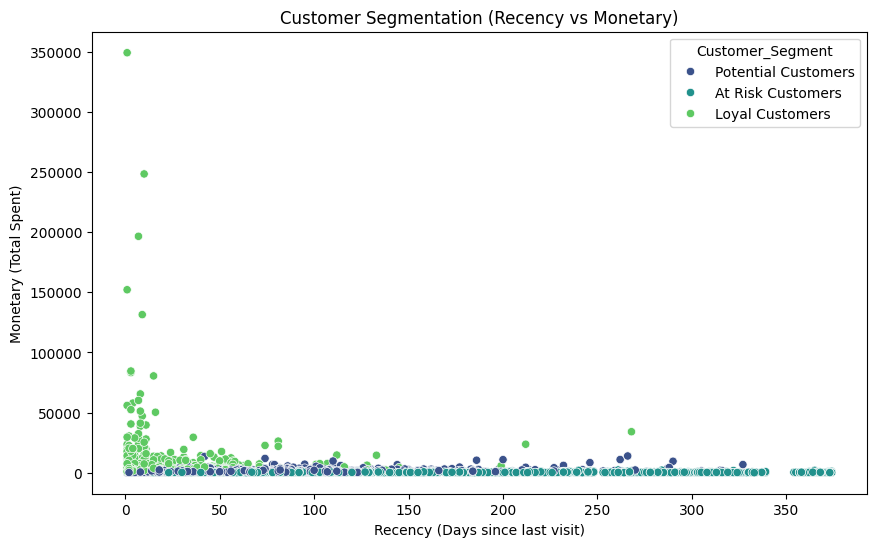

,Recency,Frequency,Monetary,Cluster,Customer_Segment
CustomerID,,,,,
12346.0,165,11,372.86,0,Potential Customers
12347.0,3,2,1323.32,0,Potential Customers
12348.0,74,1,222.16,1,At Risk Customers
12349.0,43,3,2671.14,0,Potential Customers
12351.0,11,1,300.93,0,Potential Customers


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. ক্লাস্টারের নাম দেওয়া (তোমার রেজাল্ট অনুযায়ী)
# Cluster 2 = Best (Loyal), Cluster 0 = Potential, Cluster 1 = Risk
cluster_mapping = {
    2: 'Loyal Customers',
    0: 'Potential Customers',
    1: 'At Risk Customers'
}
rfm['Customer_Segment'] = rfm['Cluster'].map(cluster_mapping)

# 2. গ্রাফ আঁকা (Recency vs Monetary)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Customer_Segment', palette='viridis')
plt.title('Customer Segmentation (Recency vs Monetary)')
plt.xlabel('Recency (Days since last visit)')
plt.ylabel('Monetary (Total Spent)')
plt.show()

# 3. ফাইনাল ডেটা দেখা
display(rfm.head())

##Model Deployment

ওয়েব অ্যাপ (Web App) বানানোর জন্য আমাদের জুপিটার নোটবুকের ৩টি জিনিস বাইরে বের করে আনতে হবে:

The Brain (Model): আমাদের ট্রেইন করা kmeans মডেল।

The Translator (Scaler): আমাদের scaler অবজেক্ট (যাতে নতুন ডেটা দিলে সেটাকে স্কেল করতে পারে)।

The Data: ক্লাস্টার করা rfm ডেটাফ্রেম (যাতে অ্যাপে আমরা গ্রাফ দেখাতে পারি)।

**Saving Artifacts for Deployment:** We save the trained K-Means model and the Scaler object using joblib. This allows us to load the model in a separate web application without retraining. We also save the processed dataset to display insights on the dashboard.

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib
from google.colab import files  # Colab না হলে এটা লাগবে না

# ১. ধরে নিচ্ছি তোমার 'rfm' টেবিলটা অলরেডি মেমোরিতে আছে
# সেফটির জন্য আমরা Cluster কলামটা ফেলে দিচ্ছি (যদি থাকে)
if 'Cluster' in rfm.columns:
    rfm = rfm.drop(columns=['Cluster'])

if 'Customer_Segment' in rfm.columns:
    rfm = rfm.drop(columns=['Customer_Segment'])

# ২. আবার নতুন করে Preprocessing করছি (Cluster কলাম ছাড়া)
rfm_log = np.log1p(rfm) # Log Transform

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log) # Scaling (এখন শুধু R, F, M আছে)

# ৩. মডেল ট্রেইন করা
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans.fit(rfm_scaled)

# ৪. এবার আসল ডেটায় আবার ক্লাস্টার বসাচ্ছি (শুধু ভিজ্যুয়ালাইজেশনের জন্য)
rfm['Cluster'] = kmeans.labels_

# ৫. ফাইলগুলো আবার সেভ করা (Clean Version)
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
rfm.to_csv('rfm_analysis.csv') # আপডেট করা ডেটা

print("Files Re-saved Successfully!")

# ৬. ডাউনলোড করা (Colab এর জন্য)
files.download('kmeans_model.pkl')
files.download('scaler.pkl')
files.download('rfm_analysis.csv')

Files Re-saved Successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>